Imports for Local

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import optuna, joblib, matplotlib, os, pyfolio, sys
from stable_baselines3 import A2C
from stable_baselines3.common.evaluation import evaluate_policy
from pyfolio import timeseries

matplotlib.use('Agg')
%matplotlib inline
import datetime
from stockstats import StockDataFrame as Sdf
from QuantumAI.config import config
from QuantumAI.config import config_tickers
from QuantumAI.preprocessors.yahoodownloader import YahooDownloader
from QuantumAI.preprocessors.preprocessors import FeatureEngineer, data_split
# from QuantumAI.env.env_portfolio import StockPortfolioEnv
# from QuantumAI.env.env_portfolioSPX import StockPortfolioEnv
from QuantumAI.env.env_portfolio_original import StockPortfolioEnv
from QuantumAI.env.env_portfolioSPXvsCash import SPXvsCASH
from QuantumAI.models.models import DRLAgent
from QuantumAI.plot.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts, show_weight_distribution
from QuantumAI.preprocessors.data_processor import DataProcessor
from QuantumAI.preprocessors.processor_yahoofinance import YahooFinanceProcessor
from QuantumAI.hyper_opt.hyperopt1 import optimize


In [122]:
spx = pd.read_csv("/Users/floriankockler/My Drive/SPX_2.csv", skiprows=6)
spx['date'] = pd.to_datetime(spx["date"], format='%m/%d/%Y')
spx



,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,MA20,tic
0,1990-01-02,359.69,353.39,351.98,359.69,66.90,66.57,NaN,331.86,344.05,349.02,SPX
1,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,349.39,SPX
2,1990-01-04,355.67,358.74,352.89,358.76,58.72,61.98,56.59,332.52,344.49,349.69,SPX
3,1990-01-05,352.20,355.65,351.35,355.67,52.64,58.36,35.17,332.83,344.66,349.88,SPX
4,1990-01-08,353.79,352.19,350.54,354.24,54.94,59.48,48.55,333.16,344.89,350.19,SPX
...,...,...,...,...,...,...,...,...,...,...,...,...
8450,2023-07-19,4565.72,4563.87,4557.48,4578.43,75.00,67.61,94.86,4043.67,4311.72,4435.98,SPX
8451,2023-07-20,4534.87,4554.38,4527.56,4564.74,67.94,64.81,53.04,4048.41,4319.65,4444.44,SPX
8452,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,4452.17,SPX
8453,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,4462.48,SPX


In [123]:
ndx = pd.read_csv("/Users/floriankockler/My Drive/NDX_2.csv", skiprows=6)
ndx['date'] = pd.to_datetime(ndx["date"], format='%m/%d/%Y')
ndx


,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,MA20,tic
0,1990-01-02,227.73,223.84,220.44,227.73,64.06,56.79,NaN,213.82,221.50,219.75,NDX
1,1990-01-03,226.10,227.73,226.10,228.94,60.09,54.71,71.55,214.06,221.40,219.72,NDX
2,1990-01-04,224.72,226.10,222.71,226.18,56.87,53.01,52.56,214.27,221.32,219.59,NDX
3,1990-01-05,223.14,224.72,222.89,224.80,53.35,51.13,36.11,214.48,221.26,219.54,NDX
4,1990-01-08,223.54,223.14,221.64,223.58,54.12,51.58,42.90,214.69,221.18,219.48,NDX
...,...,...,...,...,...,...,...,...,...,...,...,...
8450,2023-07-19,15826.35,15888.16,15781.96,15932.05,75.50,69.99,91.29,12589.11,14562.17,15202.46,NDX
8451,2023-07-20,15466.09,15717.67,15429.87,15771.84,60.26,63.23,29.71,12611.59,14605.66,15232.39,NDX
8452,2023-07-21,15425.67,15554.96,15410.57,15600.54,58.82,62.53,26.69,12632.57,14650.15,15251.56,NDX
8453,2023-07-24,15448.02,15475.15,15374.66,15504.67,59.40,62.77,32.40,12651.90,14692.16,15279.39,NDX


In [124]:
combined = pd.concat([spx, ndx], axis=0)
combined = combined.sort_values(['date','tic'], ignore_index=True)
combined

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,MA20,tic
0,1990-01-02,227.73,223.84,220.44,227.73,64.06,56.79,NaN,213.82,221.50,219.75,NDX
1,1990-01-02,359.69,353.39,351.98,359.69,66.90,66.57,NaN,331.86,344.05,349.02,SPX
2,1990-01-03,226.10,227.73,226.10,228.94,60.09,54.71,71.55,214.06,221.40,219.72,NDX
3,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,349.39,SPX
4,1990-01-04,224.72,226.10,222.71,226.18,56.87,53.01,52.56,214.27,221.32,219.59,NDX
...,...,...,...,...,...,...,...,...,...,...,...,...
16905,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,4452.17,SPX
16906,2023-07-24,15448.02,15475.15,15374.66,15504.67,59.40,62.77,32.40,12651.90,14692.16,15279.39,NDX
16907,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,4462.48,SPX
16908,2023-07-25,15593.47,15483.06,15482.04,15622.69,63.02,64.28,61.61,12672.00,14736.23,15324.61,NDX


In [125]:
eco = pd.read_csv("/Users/floriankockler/My Drive/eco.csv", skiprows=6)
eco['date'] = pd.to_datetime(eco["date"], format='%m/%d/%Y')
eco

,date,PUT Index,RXM Index,USGG2YR Index,USGG10YR Index,MOVE Index,VIX Index,NWHLSENY Index,NWHLSEND Index,USGG5YR Index,SFFRNEWS Index,US10-US2Y
0,1990-01-02,133.84,137.01,7.8750,7.9300,91.73,17.24,0.95,0.78,7.8470,0.031309,0.0550
1,1990-01-03,133.87,137.26,7.9270,7.9740,93.21,18.19,0.94,0.80,7.9110,0.033682,0.0470
2,1990-01-04,133.72,136.81,7.9100,7.9720,95.09,19.22,0.82,0.64,7.9000,0.025195,0.0620
3,1990-01-05,133.28,136.37,7.8850,7.9840,85.28,20.11,0.83,0.73,7.8960,0.047431,0.0990
4,1990-01-08,133.76,136.69,7.8930,8.0120,86.91,20.26,0.59,0.67,7.9070,0.072032,0.1190
...,...,...,...,...,...,...,...,...,...,...,...,...
8751,2023-07-19,2574.82,1504.89,4.7660,3.7483,107.19,13.76,0.96,0.70,3.9855,-0.017261,-1.0177
8752,2023-07-20,2575.25,1498.58,4.8387,3.8503,112.85,13.99,0.92,0.49,4.1017,-0.018575,-0.9884
8753,2023-07-21,2572.36,1495.57,4.8372,3.8349,106.66,13.60,0.94,0.55,4.0930,-0.010344,-1.0023
8754,2023-07-24,2579.06,1499.08,4.9191,3.8725,109.95,13.91,0.92,0.37,4.1515,-0.004883,-1.0466


In [126]:
df_merged = combined.merge(eco, on='date', how='left')
df_merged

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,...,RXM Index,USGG2YR Index,USGG10YR Index,MOVE Index,VIX Index,NWHLSENY Index,NWHLSEND Index,USGG5YR Index,SFFRNEWS Index,US10-US2Y
0,1990-01-02,227.73,223.84,220.44,227.73,64.06,56.79,NaN,213.82,221.50,...,137.01,7.8750,7.9300,91.73,17.24,0.95,0.78,7.8470,0.031309,0.0550
1,1990-01-02,359.69,353.39,351.98,359.69,66.90,66.57,NaN,331.86,344.05,...,137.01,7.8750,7.9300,91.73,17.24,0.95,0.78,7.8470,0.031309,0.0550
2,1990-01-03,226.10,227.73,226.10,228.94,60.09,54.71,71.55,214.06,221.40,...,137.26,7.9270,7.9740,93.21,18.19,0.94,0.80,7.9110,0.033682,0.0470
3,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,...,137.26,7.9270,7.9740,93.21,18.19,0.94,0.80,7.9110,0.033682,0.0470
4,1990-01-04,224.72,226.10,222.71,226.18,56.87,53.01,52.56,214.27,221.32,...,136.81,7.9100,7.9720,95.09,19.22,0.82,0.64,7.9000,0.025195,0.0620
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16905,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,...,1495.57,4.8372,3.8349,106.66,13.60,0.94,0.55,4.0930,-0.010344,-1.0023
16906,2023-07-24,15448.02,15475.15,15374.66,15504.67,59.40,62.77,32.40,12651.90,14692.16,...,1499.08,4.9191,3.8725,109.95,13.91,0.92,0.37,4.1515,-0.004883,-1.0466
16907,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,...,1499.08,4.9191,3.8725,109.95,13.91,0.92,0.37,4.1515,-0.004883,-1.0466
16908,2023-07-25,15593.47,15483.06,15482.04,15622.69,63.02,64.28,61.61,12672.00,14736.23,...,1501.63,4.8827,3.9023,109.95,14.04,0.92,0.37,4.1818,-0.004883,-0.9804


In [127]:
fe = FeatureEngineer(
                    use_technical_indicator=True,
                    use_turbulence=False,
                    user_defined_feature = False)

cleaned = fe.preprocess_data(df_merged)

df =cleaned.dropna(axis=0)
df.isna().sum()
df

Successfully added technical indicators


,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,...,SFFRNEWS Index,US10-US2Y,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,1990-01-02,227.73,223.84,220.44,227.73,64.06,56.79,71.55,213.82,221.50,...,0.031309,0.0550,0.000000,229.220168,224.609832,0.000000,66.666667,100.000000,227.730000,227.730000
8455,1990-01-02,359.69,353.39,351.98,359.69,66.90,66.57,71.55,331.86,344.05,...,0.031309,0.0550,0.000000,229.220168,224.609832,0.000000,66.666667,100.000000,359.690000,359.690000
1,1990-01-03,226.10,227.73,226.10,228.94,60.09,54.71,71.55,214.06,221.40,...,0.033682,0.0470,-0.036571,229.220168,224.609832,0.000000,66.666667,100.000000,226.915000,226.915000
8456,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,...,0.033682,0.0470,-0.020865,360.540219,357.909781,0.000000,66.666667,100.000000,359.225000,359.225000
2,1990-01-04,224.72,226.10,222.71,226.18,56.87,53.01,52.56,214.27,221.32,...,0.025195,0.0620,-0.089392,229.196792,223.169875,0.000000,-76.898982,49.935797,226.183333,226.183333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16907,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,...,-0.010344,-1.0023,61.647135,4594.093122,4310.236878,64.877680,130.895366,39.904326,4422.944667,4293.225333
8453,2023-07-24,15448.02,15475.15,15374.66,15504.67,59.40,62.77,32.40,12651.90,14692.16,...,-0.004883,-1.0466,257.405842,15916.201353,14642.568647,62.769705,73.110558,20.580513,15164.923333,14441.190833
16908,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,...,-0.004883,-1.0466,61.499949,4602.610732,4322.350268,65.775789,130.724267,41.563408,4431.635000,4301.536167
8454,2023-07-25,15593.47,15483.06,15482.04,15622.69,63.02,64.28,61.61,12672.00,14736.23,...,-0.004883,-0.9804,250.099106,15911.393328,14737.821672,64.284144,96.167351,26.033977,15200.427000,14481.748167


In [128]:
# df_combined = pd.concat([test, test_dx], axis=0)
# df_combined = df_combined.sort_values(['date','tic'], ignore_index=True)
# df_combined
# trial = fe.preprocess_data(df_combined)
# trial


In [129]:
#!SPäter BBG clean data class machen
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     use_turbulence=False,
#                     user_defined_feature = False)

# df = fe.clean_data(frame)
# df = df.dropna(axis=0)
# df["date"] = pd.to_datetime(df["date"])

bbg_full_start_date="1991-01-02"
full_end_date="2023-07-25"
bbg_train_start_date="1991-01-02"
bbg_train_end_date="2015-12-31"
bbg_validate_start_date="2016-01-01"
bbg_validate_end_date="2020-12-31"
bbg_test_start_date="2021-01-01"
bbg_test_end_date="2023-07-25"
bbg_ticker =["SPX Index"]


Imports for Colab

In [130]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import optuna, joblib, matplotlib
# from stable_baselines3 import A2C
# from stable_baselines3.common.evaluation import evaluate_policy

# matplotlib.use('Agg')
# %matplotlib inline
# import datetime
# from stockstats import StockDataFrame as Sdf
# from quantumai.config import config
# from quantumai.config import config_tickers
# from quantumai.preprocessors.yahoodownloader import YahooDownloader
# from quantumai.preprocessors.preprocessors import FeatureEngineer, data_split
# from quantumai.env.env_portfolio import StockPortfolioEnv
# from quantumai.models.models import DRLAgent
# from quantumai.plot.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline,convert_daily_return_to_pyfolio_ts
# from quantumai.preprocessors.data_processor import DataProcessor
# from quantumai.preprocessors.processor_yahoofinance import YahooFinanceProcessor
# import sys
# sys.path.append("../FinRL-Library")
# sys.path.append("../quantumai")

In [131]:
if not os.path.exists("./" + config.DATA_SAVE_DIR):
    os.makedirs("./" + config.DATA_SAVE_DIR)
if not os.path.exists("./" + config.TRAINED_MODEL_DIR):
    os.makedirs("./" + config.TRAINED_MODEL_DIR)
if not os.path.exists("./" + config.TENSORBOARD_LOG_DIR):
    os.makedirs("./" + config.TENSORBOARD_LOG_DIR)
if not os.path.exists("./" + config.RESULTS_DIR):
    os.makedirs("./" + config.RESULTS_DIR)

In [132]:
df.columns

Index(['date', 'close', 'open', 'low', 'high', 'RSI14', 'RSI30', 'RSI3',
       'MA200', 'MA50', 'MA20', 'tic', 'PUT Index', 'RXM Index',
       'USGG2YR Index', 'USGG10YR Index', 'MOVE Index', 'VIX Index',
       'NWHLSENY Index', 'NWHLSEND Index', 'USGG5YR Index', 'SFFRNEWS Index',
       'US10-US2Y', 'macd', 'boll_ub', 'boll_lb', 'rsi_30', 'cci_30', 'dx_30',
       'close_30_sma', 'close_60_sma'],
      dtype='object')

In [133]:
# dp = YahooFinanceProcessor()
# df = dp.download_data_flo(start_date=full_start_date, end_date=full_end_date, ticker_list=etf_list, time_interval="1D")
# df = df.rename(columns={"timestamp":"date"})

In [134]:
df.index = df.date.factorize()[0]
df

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,...,SFFRNEWS Index,US10-US2Y,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma
0,1990-01-02,227.73,223.84,220.44,227.73,64.06,56.79,71.55,213.82,221.50,...,0.031309,0.0550,0.000000,229.220168,224.609832,0.000000,66.666667,100.000000,227.730000,227.730000
0,1990-01-02,359.69,353.39,351.98,359.69,66.90,66.57,71.55,331.86,344.05,...,0.031309,0.0550,0.000000,229.220168,224.609832,0.000000,66.666667,100.000000,359.690000,359.690000
1,1990-01-03,226.10,227.73,226.10,228.94,60.09,54.71,71.55,214.06,221.40,...,0.033682,0.0470,-0.036571,229.220168,224.609832,0.000000,66.666667,100.000000,226.915000,226.915000
1,1990-01-03,358.76,359.66,357.89,360.59,64.92,65.48,88.64,332.20,344.28,...,0.033682,0.0470,-0.020865,360.540219,357.909781,0.000000,66.666667,100.000000,359.225000,359.225000
2,1990-01-04,224.72,226.10,222.71,226.18,56.87,53.01,52.56,214.27,221.32,...,0.025195,0.0620,-0.089392,229.196792,223.169875,0.000000,-76.898982,49.935797,226.183333,226.183333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8452,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,...,-0.010344,-1.0023,61.647135,4594.093122,4310.236878,64.877680,130.895366,39.904326,4422.944667,4293.225333
8453,2023-07-24,15448.02,15475.15,15374.66,15504.67,59.40,62.77,32.40,12651.90,14692.16,...,-0.004883,-1.0466,257.405842,15916.201353,14642.568647,62.769705,73.110558,20.580513,15164.923333,14441.190833
8453,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,...,-0.004883,-1.0466,61.499949,4602.610732,4322.350268,65.775789,130.724267,41.563408,4431.635000,4301.536167
8454,2023-07-25,15593.47,15483.06,15482.04,15622.69,63.02,64.28,61.61,12672.00,14736.23,...,-0.004883,-0.9804,250.099106,15911.393328,14737.821672,64.284144,96.167351,26.033977,15200.427000,14481.748167


In [135]:
df = df.sort_values(by=["tic", "date"])
df
stock = Sdf.retype(df.copy())
stock
unique_ticker = stock.tic.unique()
unique_ticker

array(['NDX', 'SPX'], dtype=object)

In [136]:
# add covariance matrix as states
df=df.sort_values(['date','tic'],ignore_index=True)
df.index = df.date.factorize()[0]

cov_list = []
return_list = []

# look back is one year
lookback=252
for i in range(lookback,len(df.index.unique())):
  data_lookback = df.loc[i-lookback:i,:]
  price_lookback=data_lookback.pivot_table(index = 'date',columns = 'tic', values = 'close')
  return_lookback = price_lookback.pct_change().dropna()
  return_list.append(return_lookback)

  covs = return_lookback.cov().values
  cov_list.append(covs)


df_cov = pd.DataFrame({'date':df.date.unique()[lookback:],'cov_list':cov_list,'return_list':return_list})
df = df.merge(df_cov, on='date')
df = df.sort_values(['date','tic']).reset_index(drop=True)

In [137]:
df

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,...,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,1990-12-31,200.53,199.37,198.39,200.53,61.89,57.60,59.92,206.27,188.69,...,3.202235,203.287066,194.326934,57.597757,66.601015,18.220983,194.914333,185.697333,"[[0.00018546693822883993, 0.000119093241522192...",tic NDX SPX date ...
1,1990-12-31,330.22,328.71,327.50,330.23,59.06,55.75,60.85,334.29,319.46,...,2.924538,332.631558,324.867442,55.748933,60.380411,7.442287,324.969667,316.762167,"[[0.00018546693822883993, 0.000119093241522192...",tic NDX SPX date ...
2,1991-01-02,199.77,200.53,199.04,200.80,59.55,56.80,43.39,206.17,189.19,...,2.998350,203.084732,195.053268,56.796107,64.214464,19.192477,195.408000,186.054000,"[[0.00018533093497689402, 0.000119181747471572...",tic NDX SPX date ...
3,1991-01-02,326.45,330.20,326.45,330.75,51.04,52.78,25.54,334.20,319.74,...,2.504065,332.269105,325.464895,52.782480,39.120709,3.249934,325.280667,317.011333,"[[0.00018533093497689402, 0.000119181747471572...",tic NDX SPX date ...
4,1991-01-03,196.40,199.77,196.16,199.80,50.46,53.39,15.31,206.06,189.55,...,2.535609,202.994417,195.222583,53.387634,28.543660,4.973436,195.720000,186.334667,"[[0.00018628025157379805, 0.000119883770228491...",tic NDX SPX date ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16401,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,...,61.647135,4594.093122,4310.236878,64.877680,130.895366,39.904326,4422.944667,4293.225333,"[[0.00025269533527981687, 0.000180749914571345...",tic NDX SPX date ...
16402,2023-07-24,15448.02,15475.15,15374.66,15504.67,59.40,62.77,32.40,12651.90,14692.16,...,257.405842,15916.201353,14642.568647,62.769705,73.110558,20.580513,15164.923333,14441.190833,"[[0.00025197081439871704, 0.000180258717847284...",tic NDX SPX date ...
16403,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,...,61.499949,4602.610732,4322.350268,65.775789,130.724267,41.563408,4431.635000,4301.536167,"[[0.00025197081439871704, 0.000180258717847284...",tic NDX SPX date ...
16404,2023-07-25,15593.47,15483.06,15482.04,15622.69,63.02,64.28,61.61,12672.00,14736.23,...,250.099106,15911.393328,14737.821672,64.284144,96.167351,26.033977,15200.427000,14481.748167,"[[0.00025086874030817355, 0.000179662211125842...",tic NDX SPX date ...


In [138]:
df.to_csv("dftopoptimuze.csv")
df.to_pickle("pickle.pkl")

In [139]:
# loadeddf = pd.read_csv("dftopoptimuze.csv")
# loadeddf.drop(columns=['Unnamed: 0'], inplace=True)
# loadeddf["date"] = pd.to_datetime(loadeddf["date"])

In [140]:
df

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,...,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,1990-12-31,200.53,199.37,198.39,200.53,61.89,57.60,59.92,206.27,188.69,...,3.202235,203.287066,194.326934,57.597757,66.601015,18.220983,194.914333,185.697333,"[[0.00018546693822883993, 0.000119093241522192...",tic NDX SPX date ...
1,1990-12-31,330.22,328.71,327.50,330.23,59.06,55.75,60.85,334.29,319.46,...,2.924538,332.631558,324.867442,55.748933,60.380411,7.442287,324.969667,316.762167,"[[0.00018546693822883993, 0.000119093241522192...",tic NDX SPX date ...
2,1991-01-02,199.77,200.53,199.04,200.80,59.55,56.80,43.39,206.17,189.19,...,2.998350,203.084732,195.053268,56.796107,64.214464,19.192477,195.408000,186.054000,"[[0.00018533093497689402, 0.000119181747471572...",tic NDX SPX date ...
3,1991-01-02,326.45,330.20,326.45,330.75,51.04,52.78,25.54,334.20,319.74,...,2.504065,332.269105,325.464895,52.782480,39.120709,3.249934,325.280667,317.011333,"[[0.00018533093497689402, 0.000119181747471572...",tic NDX SPX date ...
4,1991-01-03,196.40,199.77,196.16,199.80,50.46,53.39,15.31,206.06,189.55,...,2.535609,202.994417,195.222583,53.387634,28.543660,4.973436,195.720000,186.334667,"[[0.00018628025157379805, 0.000119883770228491...",tic NDX SPX date ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16401,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,...,61.647135,4594.093122,4310.236878,64.877680,130.895366,39.904326,4422.944667,4293.225333,"[[0.00025269533527981687, 0.000180749914571345...",tic NDX SPX date ...
16402,2023-07-24,15448.02,15475.15,15374.66,15504.67,59.40,62.77,32.40,12651.90,14692.16,...,257.405842,15916.201353,14642.568647,62.769705,73.110558,20.580513,15164.923333,14441.190833,"[[0.00025197081439871704, 0.000180258717847284...",tic NDX SPX date ...
16403,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,...,61.499949,4602.610732,4322.350268,65.775789,130.724267,41.563408,4431.635000,4301.536167,"[[0.00025197081439871704, 0.000180258717847284...",tic NDX SPX date ...
16404,2023-07-25,15593.47,15483.06,15482.04,15622.69,63.02,64.28,61.61,12672.00,14736.23,...,250.099106,15911.393328,14737.821672,64.284144,96.167351,26.033977,15200.427000,14481.748167,"[[0.00025086874030817355, 0.000179662211125842...",tic NDX SPX date ...


In [141]:
# train = data_split(df, bbg_train_start_date, bbg_train_end_date)
# validate = data_split(df, bbg_validate_start_date, bbg_validate_end_date)
# test = data_split(df, bbg_test_start_date, bbg_test_end_date)

In [142]:
# df.equals(loadeddf)

In [143]:
# differences = df.compare(loadeddf)

In [144]:
# print(df.dtypes)


In [145]:
# print(loadeddf.dtypes)

In [146]:
df

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,...,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,1990-12-31,200.53,199.37,198.39,200.53,61.89,57.60,59.92,206.27,188.69,...,3.202235,203.287066,194.326934,57.597757,66.601015,18.220983,194.914333,185.697333,"[[0.00018546693822883993, 0.000119093241522192...",tic NDX SPX date ...
1,1990-12-31,330.22,328.71,327.50,330.23,59.06,55.75,60.85,334.29,319.46,...,2.924538,332.631558,324.867442,55.748933,60.380411,7.442287,324.969667,316.762167,"[[0.00018546693822883993, 0.000119093241522192...",tic NDX SPX date ...
2,1991-01-02,199.77,200.53,199.04,200.80,59.55,56.80,43.39,206.17,189.19,...,2.998350,203.084732,195.053268,56.796107,64.214464,19.192477,195.408000,186.054000,"[[0.00018533093497689402, 0.000119181747471572...",tic NDX SPX date ...
3,1991-01-02,326.45,330.20,326.45,330.75,51.04,52.78,25.54,334.20,319.74,...,2.504065,332.269105,325.464895,52.782480,39.120709,3.249934,325.280667,317.011333,"[[0.00018533093497689402, 0.000119181747471572...",tic NDX SPX date ...
4,1991-01-03,196.40,199.77,196.16,199.80,50.46,53.39,15.31,206.06,189.55,...,2.535609,202.994417,195.222583,53.387634,28.543660,4.973436,195.720000,186.334667,"[[0.00018628025157379805, 0.000119883770228491...",tic NDX SPX date ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16401,2023-07-21,4536.34,4550.16,4535.79,4555.00,68.09,64.88,54.47,4052.70,4327.99,...,61.647135,4594.093122,4310.236878,64.877680,130.895366,39.904326,4422.944667,4293.225333,"[[0.00025269533527981687, 0.000180749914571345...",tic NDX SPX date ...
16402,2023-07-24,15448.02,15475.15,15374.66,15504.67,59.40,62.77,32.40,12651.90,14692.16,...,257.405842,15916.201353,14642.568647,62.769705,73.110558,20.580513,15164.923333,14441.190833,"[[0.00025197081439871704, 0.000180258717847284...",tic NDX SPX date ...
16403,2023-07-24,4554.64,4543.39,4541.29,4563.41,70.02,65.78,71.01,4056.52,4336.33,...,61.499949,4602.610732,4322.350268,65.775789,130.724267,41.563408,4431.635000,4301.536167,"[[0.00025197081439871704, 0.000180258717847284...",tic NDX SPX date ...
16404,2023-07-25,15593.47,15483.06,15482.04,15622.69,63.02,64.28,61.61,12672.00,14736.23,...,250.099106,15911.393328,14737.821672,64.284144,96.167351,26.033977,15200.427000,14481.748167,"[[0.00025086874030817355, 0.000179662211125842...",tic NDX SPX date ...


In [147]:
# fe = FeatureEngineer(
#                     use_technical_indicator=True,
#                     use_turbulence=False,
#                     user_defined_feature = False)

# df = fe.preprocess_data(df)
# df

In [148]:
pickletest =  pd.read_pickle("pickle.pkl")

In [149]:
df = pickletest

In [150]:
train = data_split(df, bbg_train_start_date, bbg_train_end_date)
validate = data_split(df, bbg_validate_start_date, bbg_validate_end_date)
test = data_split(df, bbg_test_start_date, bbg_test_end_date)

In [151]:
stock_dimension = len(train.tic.unique())
state_space = stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 2, State Space: 2


Old ENV kwargs

NEW ENV kwards for SPX vs. Cash

In [152]:
eco_indicator_list = ["PUT Index",
                      "RXM Index",
                      "MOVE Index",
                      "USGG30YR Index",	
                      "VIX Index",
                      "NWHLSENY Index",
                      "USGG10YR Index",	
                      "USGG5YR Index",	
                      "SFFRNEWS Index",	
                      "DXY Curncy"
]
new_tech_indics = ['RSI14', 'RSI30', 'RSI3',
       'MA200', 'MA50', 'MA20', 'PUT Index', 'RXM Index',
       'USGG2YR Index', 'USGG10YR Index', 'MOVE Index', 'VIX Index',
       'NWHLSENY Index', 'NWHLSEND Index', 'USGG5YR Index', 'SFFRNEWS Index',
       'US10-US2Y']
all_techs = ['RSI14', 'RSI30', 'RSI3',
       'MA200', 'MA50', 'MA20', 'PUT Index', 'RXM Index',
       'USGG2YR Index', 'USGG10YR Index', 'MOVE Index', 'VIX Index',
       'NWHLSENY Index', 'NWHLSEND Index', 'USGG5YR Index', 'SFFRNEWS Index',
       'US10-US2Y', 'macd', 'boll_ub', 'boll_lb',  'cci_30', 'dx_30',
       'close_30_sma', 'close_60_sma']
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    # "eco_indicator_list": eco_indicator_list, 
    # "tech_indicator_list": new_tech_indics, 
    "tech_indicator_list": all_techs, 
    # "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    # "cov": False
    
}

e_train_gym = StockPortfolioEnv(df = train, **env_kwargs)
# !FLO New validation set
e_validate_gym = StockPortfolioEnv(df = validate, **env_kwargs)


Observation space Box(-inf, inf, (26, 2), float32)
state space 2
Observation space Box(-inf, inf, (26, 2), float32)
state space 2


In [153]:
train

,date,close,open,low,high,RSI14,RSI30,RSI3,MA200,MA50,...,macd,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,cov_list,return_list
0,1991-01-02,199.77,200.53,199.04,200.80,59.55,56.80,43.39,206.17,189.19,...,2.998350,203.084732,195.053268,56.796107,64.214464,19.192477,195.408000,186.054000,"[[0.00018533093497689402, 0.000119181747471572...",tic NDX SPX date ...
0,1991-01-02,326.45,330.20,326.45,330.75,51.04,52.78,25.54,334.20,319.74,...,2.504065,332.269105,325.464895,52.782480,39.120709,3.249934,325.280667,317.011333,"[[0.00018533093497689402, 0.000119181747471572...",tic NDX SPX date ...
1,1991-01-03,196.40,199.77,196.16,199.80,50.46,53.39,15.31,206.06,189.55,...,2.535609,202.994417,195.222583,53.387634,28.543660,4.973436,195.720000,186.334667,"[[0.00018628025157379805, 0.000119883770228491...",tic NDX SPX date ...
1,1991-01-03,321.91,326.46,321.90,326.53,43.40,49.50,12.47,334.10,319.88,...,1.783934,333.141944,324.148056,49.501121,-24.893497,12.555330,325.366333,317.151833,"[[0.00018628025157379805, 0.000119883770228491...",tic NDX SPX date ...
2,1991-01-04,196.83,196.40,195.67,198.08,51.48,53.75,24.64,205.97,189.92,...,2.178470,203.016094,194.980906,53.753968,15.716780,2.744251,196.170667,186.721333,"[[0.0001861334885753973, 0.0001196096846780689...",tic NDX SPX date ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6296,2015-12-28,2056.50,2057.77,2044.20,2057.77,50.62,50.71,59.76,2061.49,2065.14,...,-4.428211,2106.573325,2001.876675,50.713085,-25.136480,8.777923,2060.662333,2053.974667,"[[0.00012539998182513627, 0.000103161388526744...",tic NDX SPX date ...
6297,2015-12-29,4691.08,4645.08,4644.32,4702.74,56.91,54.95,86.73,4472.99,4626.90,...,2.532235,4746.436586,4510.665414,54.950690,71.475191,0.833402,4635.317333,4582.929667,"[[0.00012626156054781397, 0.000103786999700811...",tic NDX SPX date ...
6297,2015-12-29,2078.36,2060.54,2060.54,2081.56,54.96,52.85,78.45,2061.48,2066.04,...,-1.770284,2106.262560,2001.982440,52.849490,39.320468,2.873594,2062.506333,2056.091333,"[[0.00012626156054781397, 0.000103786999700811...",tic NDX SPX date ...
6298,2015-12-30,4652.01,4687.16,4651.73,4688.66,52.97,53.14,56.74,4474.37,4630.69,...,4.757756,4736.490657,4514.196343,53.141166,43.969731,0.833402,4638.202000,4588.272667,"[[0.00012634548004045128, 0.000103893442941983...",tic NDX SPX date ...


In [154]:
# train.to_csv("train_fails.csv")

In [155]:
env_train, _ = e_train_gym.get_sb_env()
env_validate, _ = e_validate_gym.get_sb_env()


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [156]:
agent = DRLAgent(env = env_train)
A2C_PARAMS = {"n_steps": 5, "ent_coef": 0.005, "learning_rate": 0.0002}
model_a2c = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS, tensorboard_log='/Users/floriankockler/Documents/GitHub.nosync/TrainedModels/TensorboardLogs/')

{'n_steps': 5, 'ent_coef': 0.005, 'learning_rate': 0.0002}
Using cpu device


In [157]:
trained_a2c = agent.train_model(model=model_a2c, 
                                tb_log_name='a2c_etf',
                                total_timesteps=50000)

Logging to /Users/floriankockler/Documents/GitHub.nosync/TrainedModels/TensorboardLogs/a2c_etf_44


-------------------------------------
| time/                 |           |
|    fps                | 797       |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -2.82     |
|    explained_variance | 0         |
|    learning_rate      | 0.0002    |
|    n_updates          | 99        |
|    policy_loss        | 1.05e+07  |
|    reward             | 1526813.1 |
|    std                | 0.992     |
|    value_loss         | 2.42e+13  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 884       |
|    iterations         | 200       |
|    time_elapsed       | 1         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -2.82     |
|    explained_variance | -1.19e-07 |
|    learning_rate      | 0.0002    |
|    n_updat

Optimize

In [158]:
# optimize(e_validate_gym,env_train, n_trial_runs=40)

In [159]:
# trained_a2c.save('/Users/floriankockler/Documents/GitHub.nosync/TrainedModels//trained_a2c_etf.zip')

Trading

In [160]:
trade = data_split(df,bbg_validate_start_date, bbg_validate_end_date)
e_validate_gym = StockPortfolioEnv(df = validate, **env_kwargs)


Observation space Box(-inf, inf, (26, 2), float32)
state space 2


In [161]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_validate_gym)


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



begin_total_asset:1000000
end_total_asset:2551607.519508126
Sharpe:  0.9942453448769466
hit end!


In [162]:
df_actions.to_csv('df_actions.csv')
df_actions

,NDX,SPX
date,,
2016-01-04,0.500000,0.500000
2016-01-05,0.731059,0.268941
2016-01-06,0.731059,0.268941
2016-01-07,0.731059,0.268941
2016-01-08,0.731059,0.268941
...,...,...
2020-12-23,0.731059,0.268941
2020-12-24,0.731059,0.268941
2020-12-28,0.731059,0.268941


Backtest

In [163]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [164]:
df_daily_return

,date,daily_return
0,2016-01-04,0.000000
1,2016-01-05,-0.001682
2,2016-01-06,-0.010081
3,2016-01-07,-0.029117
4,2016-01-08,-0.008849
...,...,...
1253,2020-12-23,-0.003503
1254,2020-12-24,0.004295
1255,2020-12-28,0.009699
1256,2020-12-29,-0.000335


In [165]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return           0.206402
Cumulative returns      1.551608
Annual volatility       0.211387
Sharpe ratio            0.994245
Calmar ratio            0.698212
Stability               0.934765
Max drawdown           -0.295615
Omega ratio             1.222207
Sortino ratio           1.385151
Skew                   -0.600590
Kurtosis               13.786346
Tail ratio              0.895237
Daily value at risk    -0.025798
Alpha                   0.000000
Beta                    1.000000
dtype: float64

In [166]:
%matplotlib inline
# show_weight_distribution(df_actions)


Baselinestats

In [167]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^SPX", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1257, 8)
Annual return          0.131479
Cumulative returns     0.851798
Annual volatility      0.192397
Sharpe ratio           0.739502
Calmar ratio           0.387558
Stability              0.882352
Max drawdown          -0.339250
Omega ratio            1.173105
Sortino ratio          1.017377
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.854454
Daily value at risk   -0.023675
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (1884, 8)


Start date,2016-01-04
End date,2020-12-30
Total months,59
,Backtest
Annual return,20.64%
Cumulative returns,155.161%
Annual volatility,21.139%
Sharpe ratio,0.99
Calmar ratio,0.70
Stability,0.93
Max drawdown,-29.562%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,29.56,2020-02-19,2020-03-23,2020-06-08,79
1,21.99,2018-08-29,2018-12-24,2019-04-17,166
2,11.92,2020-09-02,2020-09-23,2020-12-01,65
3,11.16,2016-01-04,2016-02-11,2016-03-29,62
4,10.19,2018-01-26,2018-02-08,2018-03-12,32


Stress Events,mean,min,max
New Normal,0.07%,-4.07%,3.49%
Covid,0.14%,-12.14%,9.86%


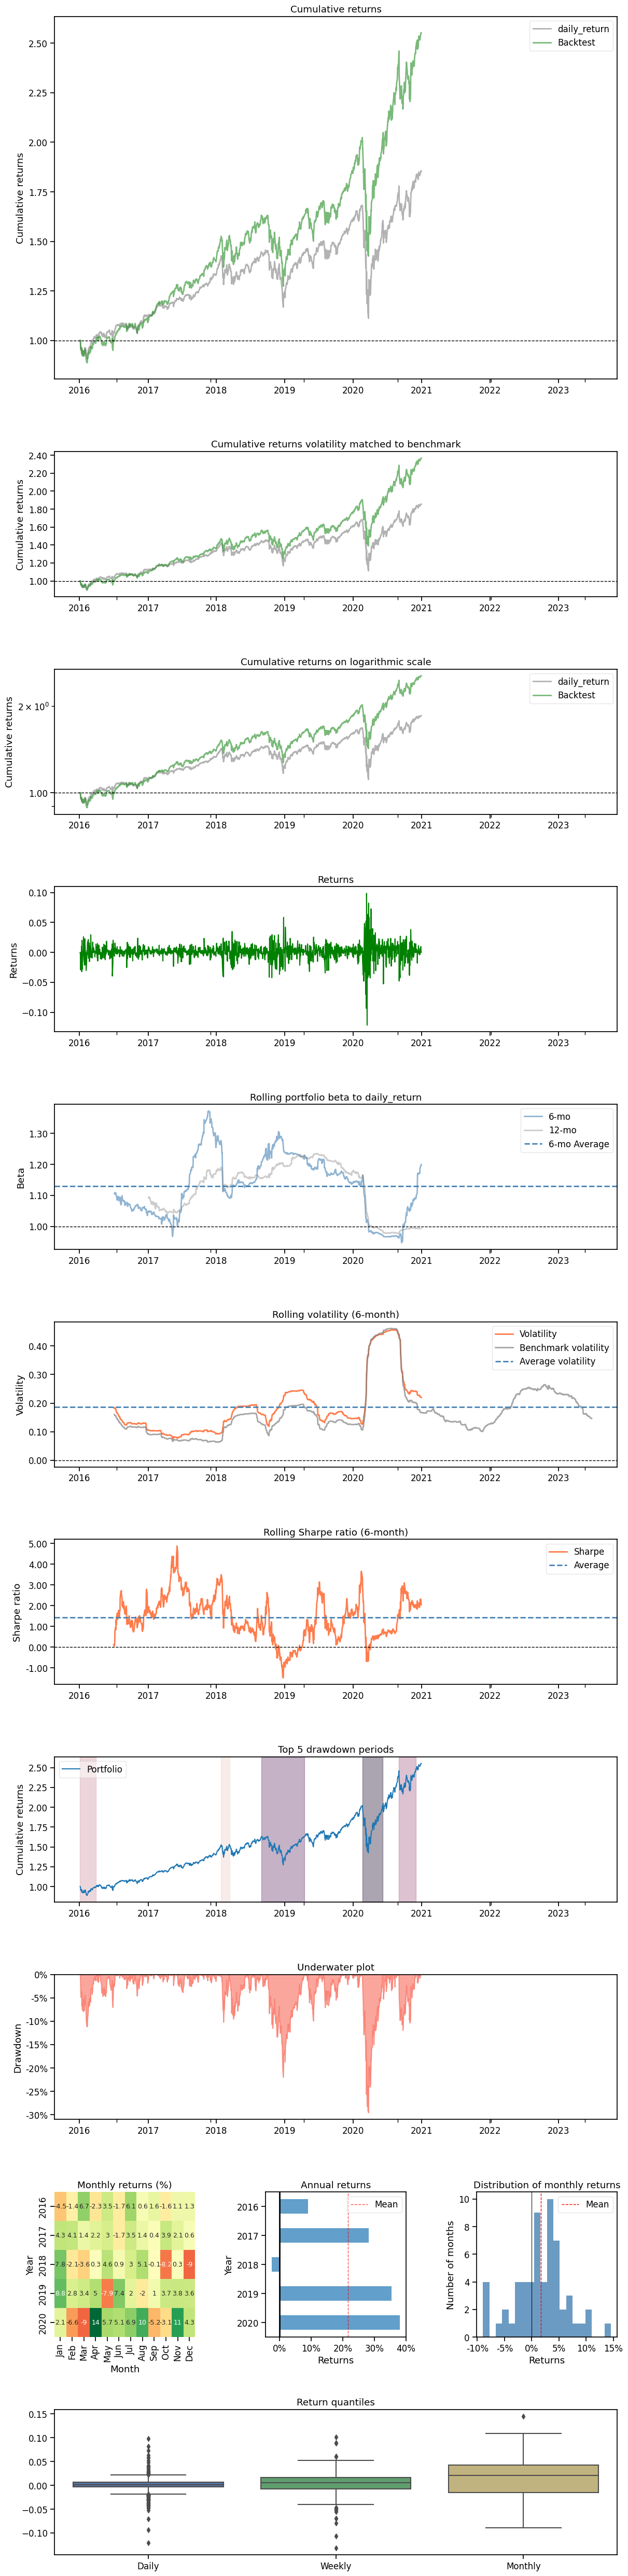

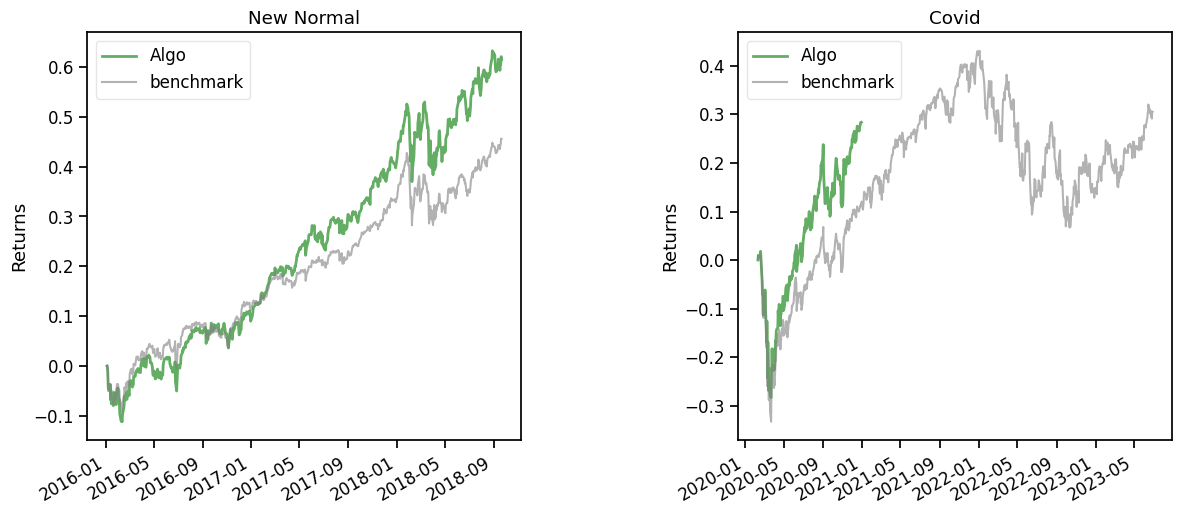

In [168]:
%matplotlib inline
baseline_df = get_baseline(
        ticker='^SPX', start=df_daily_return.loc[0,'date'], end='2023-06-29'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
        
                                       benchmark_rets=baseline_returns, set_context=False)

Trading

In [169]:
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    # "eco_indicator_list": eco_indicator_list, 
    # "tech_indicator_list": new_tech_indics, 
    "tech_indicator_list": all_techs, 
    # "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 1e-4,
    # "cov": False
    
}
e_test_gym = StockPortfolioEnv(df = test, **env_kwargs)


Observation space Box(-inf, inf, (26, 2), float32)
state space 2


In [170]:
# optimized_a2c = agent.train_model(model=model_a2c, 
#                                 tb_log_name='a2c_etf',
#                                 total_timesteps=50000)

In [171]:
#Params from Optimizer
env_kwargs = {
    "hmax": 100, 
    "initial_amount": 1000000, 
    "transaction_cost_pct": 0.001, 
    "state_space": state_space, 
    "stock_dim": stock_dimension,
    # "eco_indicator_list": eco_indicator_list, 
    # "tech_indicator_list": new_tech_indics, 
    "tech_indicator_list": all_techs, 
    # "tech_indicator_list": config.INDICATORS, 
    "action_space": stock_dimension, 
    "reward_scaling": 3.592254438135163e-05,
    # "cov": False
    
}
A2C_PARAMS_Optimized = {

    "learning_rate": 0.0004971341790917652,
    "n_steps": 30,
    "gamma": 0.916282082006916,
    "gae_lambda": 0.8012238358841213,
    "ent_coef": 0.001972952970777057,
    "vf_coef": 0.3380424108172147,
    "max_grad_norm": 0.2221179836522716,
    # "reward_scaling": 3.592254438135163e-05,
    # "lookback": 420,
}
e_test_gym = StockPortfolioEnv(df = test, **env_kwargs)

Observation space Box(-inf, inf, (26, 2), float32)
state space 2


In [172]:
env_test, _ = e_test_gym.get_sb_env()
agent = DRLAgent(env = env_test)
model_a2c_optimized = agent.get_model(model_name="a2c",model_kwargs = A2C_PARAMS_Optimized, tensorboard_log='/Users/floriankockler/Documents/GitHub.nosync/TrainedModels/TensorboardLogs/')

{'learning_rate': 0.0004971341790917652, 'n_steps': 30, 'gamma': 0.916282082006916, 'gae_lambda': 0.8012238358841213, 'ent_coef': 0.001972952970777057, 'vf_coef': 0.3380424108172147, 'max_grad_norm': 0.2221179836522716}
Using cpu device


/Users/floriankockler/anaconda3/envs/py310/lib/python3.10/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning:

You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.



In [173]:
df_daily_return, df_actions = DRLAgent.DRL_prediction(model=trained_a2c,
                        environment = e_test_gym)


begin_total_asset:1000000
end_total_asset:1223693.0490629936
Sharpe:  0.4583989476732993
hit end!


In [174]:
df_actions

,NDX,SPX
date,,
2021-01-04,0.500000,0.500000
2021-01-05,0.731059,0.268941
2021-01-06,0.731059,0.268941
2021-01-07,0.731059,0.268941
2021-01-08,0.731059,0.268941
...,...,...
2023-07-18,0.731059,0.268941
2023-07-19,0.731059,0.268941
2023-07-20,0.731059,0.268941


In [175]:
DRL_strat = convert_daily_return_to_pyfolio_ts(df_daily_return)
perf_func = timeseries.perf_stats 
perf_stats_all = perf_func( returns=DRL_strat, 
                              factor_returns=DRL_strat, 
                                positions=None, transactions=None, turnover_denom="AGB")

In [176]:
print("==============DRL Strategy Stats===========")
perf_stats_all

==============DRL Strategy Stats===========


Annual return          0.082464
Cumulative returns     0.223693
Annual volatility      0.231118
Sharpe ratio           0.458399
Calmar ratio           0.251503
Stability              0.106981
Max drawdown          -0.327885
Omega ratio            1.079660
Sortino ratio          0.652490
Skew                  -0.102134
Kurtosis               1.183445
Tail ratio             1.005622
Daily value at risk   -0.028698
Alpha                  0.000000
Beta                   1.000000
dtype: float64

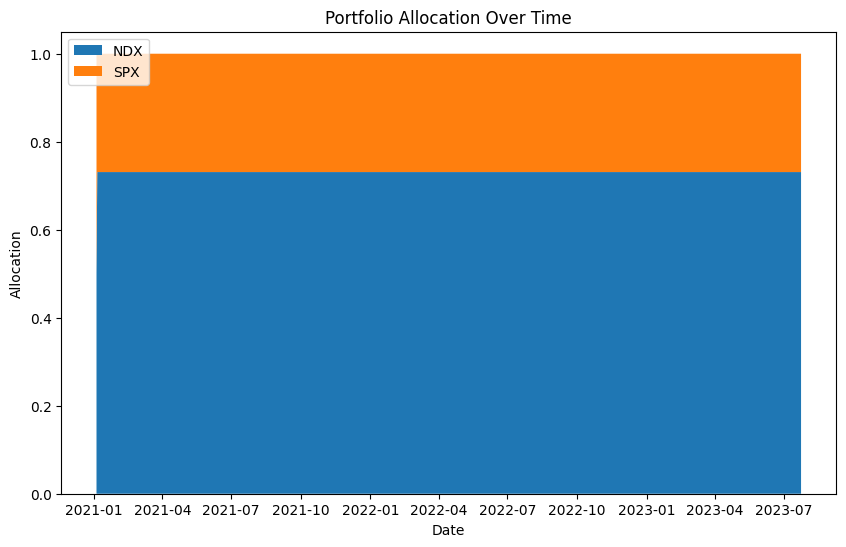

In [177]:
%matplotlib inline
show_weight_distribution(df_actions)


In [178]:
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^SPX", 
        start = df_daily_return.loc[0,'date'],
        end = df_daily_return.loc[len(df_daily_return)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (641, 8)
Annual return          0.083338
Cumulative returns     0.225822
Annual volatility      0.184091
Sharpe ratio           0.527564
Calmar ratio           0.327779
Stability              0.025701
Max drawdown          -0.254251
Omega ratio            1.093309
Sortino ratio          0.752319
Skew                        NaN
Kurtosis                    NaN
Tail ratio             0.996090
Daily value at risk   -0.022808
dtype: float64


[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (625, 8)


Start date,2021-01-04
End date,2023-06-28
Total months,29
,Backtest
Annual return,7.003%
Cumulative returns,18.279%
Annual volatility,23.327%
Sharpe ratio,0.41
Calmar ratio,0.21
Stability,0.16
Max drawdown,-32.788%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,32.79,2021-12-27,2022-10-14,NaT,NaN
1,8.82,2021-02-12,2021-03-08,2021-04-08,40
2,6.93,2021-09-07,2021-10-04,2021-10-28,38
3,6.22,2021-04-16,2021-05-12,2021-06-11,41
4,4.92,2021-11-19,2021-12-20,2021-12-27,27


Stress Events,mean,min,max
Covid,0.04%,-5.21%,6.96%


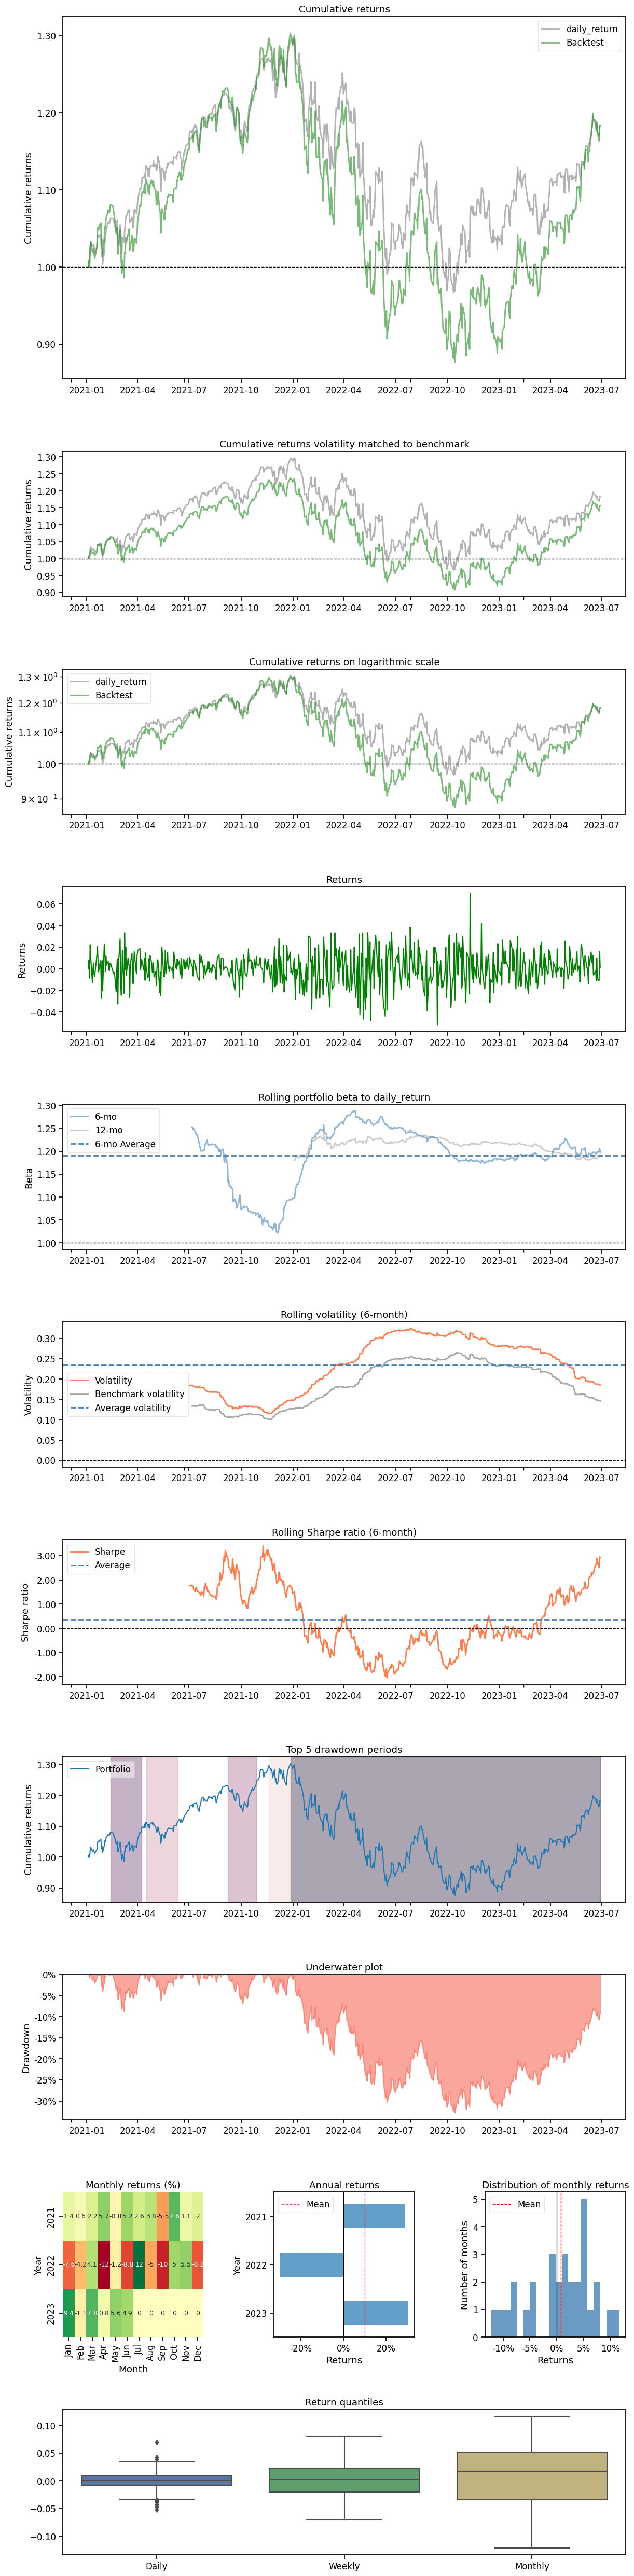

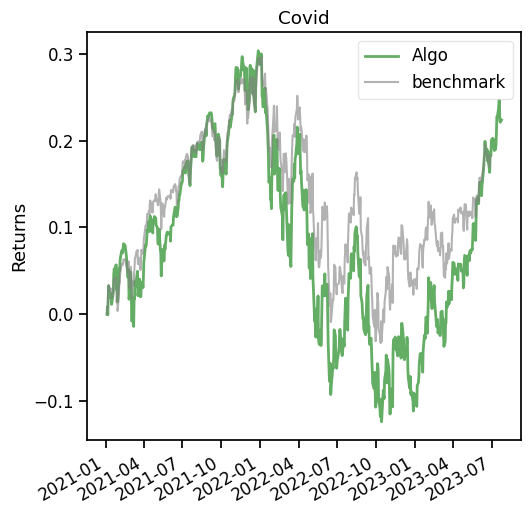

In [179]:
%matplotlib inline
baseline_df = get_baseline(
        ticker='^SPX', start=df_daily_return.loc[0,'date'], end='2023-06-29'
    )

baseline_returns = get_daily_return(baseline_df, value_col_name="close")

with pyfolio.plotting.plotting_context(font_scale=1.1):
        pyfolio.create_full_tear_sheet(returns = DRL_strat,
        
                                       benchmark_rets=baseline_returns, set_context=False)